In [65]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [66]:
tickers = ['SPY','TLT','GLD','QQQ','VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days = 10*365)

In [67]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [68]:
import numpy as np

In [69]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [70]:
log_returns = log_returns.dropna()

In [71]:
cov_matrix = log_returns.cov()*252

In [72]:
cov_matrix

,SPY,TLT,GLD,QQQ,VTI
SPY,0.031170,-0.005405,0.001332,0.035933,0.031699
TLT,-0.005405,0.023252,0.006607,-0.004684,-0.005363
GLD,0.001332,0.006607,0.019784,0.001923,0.001449
QQQ,0.035933,-0.004684,0.001923,0.047926,0.036479
VTI,0.031699,-0.005363,0.001449,0.036479,0.032503


In [73]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [74]:
!pip install fredapi
from fredapi import Fred

In [75]:
fred = Fred(api_key='243800491de18520624c18f89063c4b5')

In [76]:
ten_year_treasury = fred.get_series('DGS10')/100

In [77]:
risk_free_rate = ten_year_treasury.iloc[-1]

In [78]:
risk_free_rate

0.0455

In [79]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [90]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [91]:
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [92]:
import scipy.optimize as optimize
from scipy.optimize import minimize
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [93]:
optimal_weights = optimized_results.x

In [94]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
SPY: 0.0866
TLT: 0.0000
GLD: 0.4134
QQQ: 0.5000
VTI: 0.0000


In [95]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 0.1277
Expected Volatility: 0.1400
Sharpe Ratio: 0.5870


In [96]:
from matplotlib import pyplot as plt

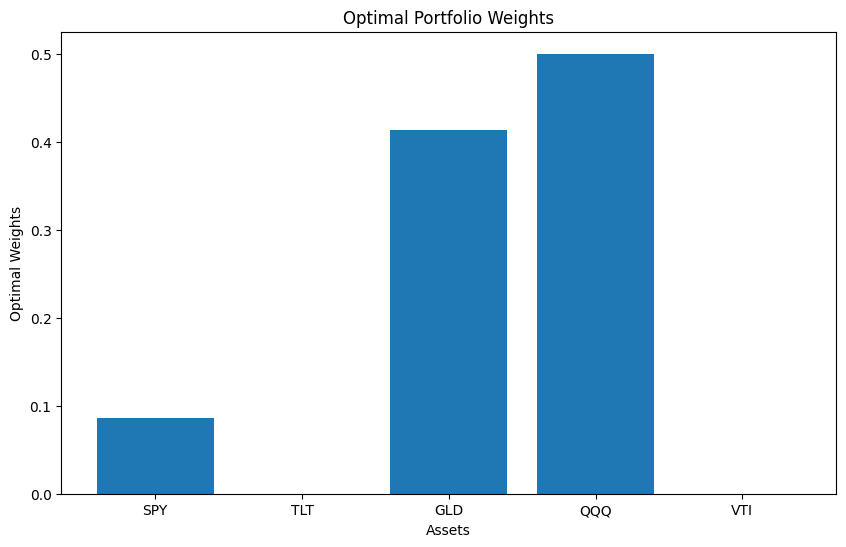

In [97]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [104]:
!pip install ace_tools
from scipy import stats


def historical_var(log_returns, confidence_level=0.95):
    return np.percentile(log_returns, (1 - confidence_level) * 100)

def parametric_var(log_returns, confidence_level=0.95):
    mean_return = log_returns.mean()
    std_dev = log_returns.std()
    z_score = stats.norm.ppf(1 - confidence_level)
    return mean_return + z_score * std_dev

confidence_level = 0.95

var_historical = log_returns.apply(historical_var, confidence_level=confidence_level)
var_parametric = log_returns.apply(parametric_var, confidence_level=confidence_level)

var_results = pd.DataFrame({'Historical VaR': var_historical, 'Parametric VaR': var_parametric})

display(var_results)

,Historical VaR,Parametric VaR
SPY,-0.016863,-0.017793
TLT,-0.015411,-0.015868
GLD,-0.014143,-0.014273
QQQ,-0.022896,-0.022006
VTI,-0.017032,-0.018197
